In [ ]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [ ]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.2 MB/s 


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH=r"/content/gdrive/MyDrive/bioinformatics_final_project-main/"


In [ ]:
# Apunto a la carpeta del drive
import sys
import os

sys.path.append(os.path.abspath(PATH))

In [ ]:

import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [ ]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [ ]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [ ]:
df = pd.read_csv(PATH +'data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [ ]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20
print(max_sequence_len)

227


In [ ]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [ ]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

In [ ]:
X.shape

(5663,)

In [ ]:
y.shape

(5663,)

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [ ]:
from dataaug import SmilesEnumerator

In [ ]:

sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1ccc(COc2cccc(-n3nc(OCC)oc3=O)c2)cc1
O=c1n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
C(C)Oc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
c1ccc(COc2cccc(-n3nc(OCC)oc3=O)c2)cc1
c1(=O)n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
c1ccc(OCc2ccccc2)cc1-n1c(=O)oc(OCC)n1
C(Oc1cccc(-n2nc(OCC)oc2=O)c1)c1ccccc1
c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
c1(OCC)oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1cc(COc2cccc(-n3nc(OCC)oc3=O)c2)ccc1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [ ]:
from datagen import DataGenerator

In [ ]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [ ]:
print(len(dgen))

354


In [ ]:
len(dgen) * dgen.batch_size

5664

In [ ]:
dgen

In [ ]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(y_train), len(X_test)

(4530, 4530, 1133)

In [ ]:
X_train

array(['COc1ccc(C(F)(F)F)c[n+]1C.F[B-](F)(F)F',
       '[Cl-].[Cl-].c1cc[n+](COC[n+]2ccccc2)cc1',
       'CCOC(=O)C1=C(C)Oc2nc3c(c(N)c2[C@H]1c1ccccc1)CCCC3', ...,
       'O=[N+]([O-])c1ccccc1-c1nnc(Nc2ncccn2)o1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [ ]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [ ]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [ ]:
X_b.shape

(109, 227)

# Network Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

Se probaron diferentes modelos

In [ ]:
#Modelo 1
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    max_pool_div = 4
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=2, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=3, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(1)(dense)
    model = tf.keras.models.Model(input_x, dense)
    return model

In [ ]:
# Modelo 2
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size+1, embedding_size, name='embedding' )(input_x) #BLoque de embeddings
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding) # Implementar
        max_p = L.GlobalMaxPool1D()(conv) # Implementar
        pooled_outputs.append(max_p)

        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='linear')(embedding) # Implementar
        max_p = L.GlobalMaxPool1D()(conv) # Implementar
        pooled_outputs.append(max_p)

        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding) # Implementar
        max_p = L.GlobalMaxPool1D()(conv) # Implementar
        pooled_outputs.append(max_p)

    h_pool = L.Concatenate()(pooled_outputs)
    #dense = L.Flatten()(h_pool)
    dense = L.Dense (256, activation='relu')(h_pool) # Capa densa 1
    dense = L.Dense (128, activation='linear')(dense) # Capa densa 1
    dense = L.Dense (64, activation='linear')(dense) # Capa densa 1
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

In [ ]:
# Modelo 2b
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size+1, embedding_size, name='embedding' )(input_x) #BLoque de embeddings
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding) # Implementar
        max_p = L.GlobalMaxPool1D()(conv) # Implementar
        pooled_outputs.append(max_p)

        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='linear')(embedding) # Implementar
        max_p = L.GlobalMaxPool1D()(conv) # Implementar
        pooled_outputs.append(max_p)

        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding) # Implementar
        max_p = L.GlobalMaxPool1D()(conv) # Implementar
        pooled_outputs.append(max_p)

    h_pool = L.Concatenate()(pooled_outputs)
    #dense = L.Flatten()(h_pool)
    dense = L.Dense (256, activation='relu')(h_pool) # Capa densa 1
    dense = L.Dense (128, activation='linear')(dense) # Capa densa 1
    dense = L.Dense (64, activation='relu')(dense) # Capa densa 1
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

In [ ]:
#Modelo 3
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    max_pool_div = 4
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=2, activation='linear')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=3, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(256, activation='relu')(dense)
    dense = L.Dense(128, activation='linear')(dense)
    dense = L.Dense(64, activation='linear')(dense)
    dense = L.Dense(1)(dense)
    model = tf.keras.models.Model(input_x, dense)
    return model

In [ ]:
# Modelo 4
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size+1, embedding_size, name='embedding' )(input_x) #BLoque de embeddings
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D (filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding) # Implementar
        max_p = L.MaxPool1D(100)(conv) # Implementar
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense (128, activation='relu')(dense) # Capa densa 1
    dense = L.Dense (32, activation='linear')(dense) # Capa densa 1
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

In [ ]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5) # Tamaño del Kernel
NUM_FILTERS = 128 #canales
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2

In [ ]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 227, 128)     49280       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 227, 128)     49280       ['embedding[0][0]']              
                                                                                              

In [ ]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [ ]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [ ]:
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test)

Epoch 1/100
36/36 [==============================] - 3s 74ms/step - loss: 0.2010 - R2: 0.9197 - val_loss: 0.6952 - val_R2: 0.7554
Epoch 2/100
36/36 [==============================] - 3s 73ms/step - loss: 0.2019 - R2: 0.9204 - val_loss: 0.7055 - val_R2: 0.7500
Epoch 3/100
36/36 [==============================] - 3s 72ms/step - loss: 0.2095 - R2: 0.9191 - val_loss: 0.7035 - val_R2: 0.7379
Epoch 4/100
36/36 [==============================] - 3s 72ms/step - loss: 0.1809 - R2: 0.9307 - val_loss: 0.7000 - val_R2: 0.7547
Epoch 5/100
36/36 [==============================] - 3s 72ms/step - loss: 0.2045 - R2: 0.9221 - val_loss: 0.6900 - val_R2: 0.7624
Epoch 6/100
36/36 [==============================] - 3s 71ms/step - loss: 0.2096 - R2: 0.9190 - val_loss: 0.7062 - val_R2: 0.7462
Epoch 7/100
36/36 [==============================] - 3s 72ms/step - loss: 0.2067 - R2: 0.9186 - val_loss: 0.6992 - val_R2: 0.7625
Epoch 8/100
36/36 [==============================] - 3s 72ms/step - loss: 0.2176 - R2: 0.9

In [ ]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [ ]:
X_test_eval.shape, y_test.shape

((1133, 227), (1133,))

In [ ]:
y_pred = model.predict(X_test_eval)

# Score

In [ ]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.7715329098228815

Modelo 1: R2 0.7418495435295415  -   embed_128_text_cnn_aug_100x100_0.0001_MOD1 Filter size (3,4,5) Num_fiters=128

**Modelo 2: R2 0.7715329098228815 embed_128_text_cnn_aug_256_128_64_0.0001_MOD2 Filter size (3,4,5) Num_fiters=128**

Modelo 2b: 0.643046463354434 'models/embed_128_text_cnn_aug_256_128_64_0001_m2b.h5' (relu / linear / relu) Filter size (3,4,5) Num_fiters=128

Modelo 3: 0.6523163981472493 'models/embed_128_text_cnn_aug_100x100_0.0001_m3.h5' Filter size (3,4,5) Num_fiters=128

Modelo 4: 0.643046463354434'models/embed_128_text_cnn_aug_100x100_0.0001_m4
Filter size (3,4,5) Num_fiters=128

In [ ]:
filename = 'models/embed_128_text_cnn_aug_256_128_64_0.0001_MOD2.h5'
model.save(filename)

In [ ]:
model.save(PATH+'models/embed_128_text_cnn_aug_256_128_64_0.0001_MOD2.h5', )

### Mejor Modelo:

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 227, 128)     49280       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 227, 128)     49280       ['embedding[0][0]']              
                                                                                              

**Lo obtuvimos con el Modelo 2 embed_128_text_cnn_aug_256X128X64_0.0001 Filter size (3,4,5) Num_fiters=128 obteniendo un R2 de 0.7715329098228815**

Respecto al modelo anterior (LSTM) no sólo se le cambio la arquitectura, sino también que tanto la data augementation como la tokenizacion se cambio con sentido quimico entonces eso hace que obtengamos mejores resultados.

# Load model (solo si se grabo el modelo)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
filename = 'models/embed_128_text_cnn_aug_256_128_64_0.0001_MOD2.h5'


In [ ]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [ ]:
# model_loaded.summary()

In [ ]:
y_pred = model_loaded.predict(X_test_eval)

In [ ]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.7715329098228815

# Evaluación

<function matplotlib.pyplot.show>

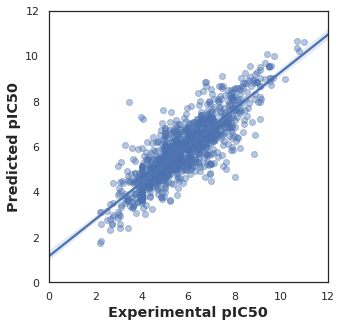

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

## TSNE

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [ ]:
embedings = model.layers[1].get_weights()[0][1:]

In [ ]:
embedings.shape

(42, 128)

In [ ]:
if embedings.shape[1] == 2:
    print('TSNE not necesary. Already in R2')
    X_2d = embedings.copy()
else:
    tsne = TSNE(2)
    X_2d = tsne.fit_transform(embedings)
    

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


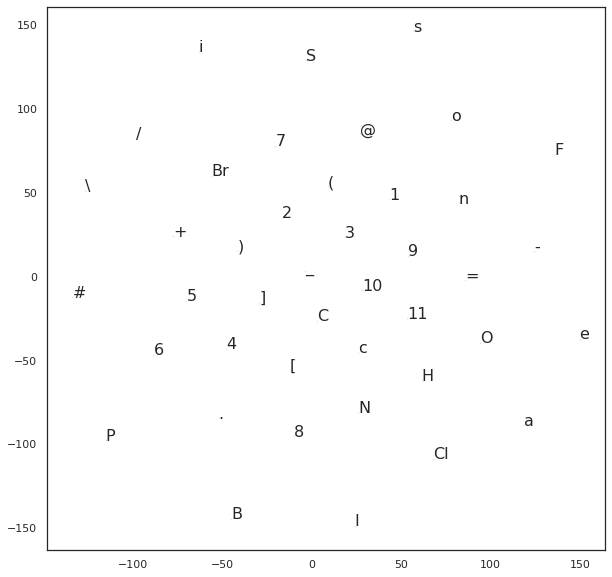

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=1, alpha=0.1)
for i, t in enumerate(smiles_dict):
    plt.text(X_2d[i, 0], X_2d[i, 1], t, fontsize=16)